In [1]:
from google.colab import drive
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.nn.utils import weight_norm
from sklearn.preprocessing import StandardScaler
import torch.nn.utils 
import torch
import copy
import math
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
!pip install optuna

     |████████████████████████████████| 266kB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 31.0MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 112kB 22.4MB/s 
     |████████████████████████████████| 133kB 25.4MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=5b285eb9e50648a8e81ff08fcd0efd209d66104c4cb3ac03dd54a40e0dcc07d1
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=1b8893c9ea843edb026d3f6e714eaf454f2aca2e0e640354d312a13c52e4f48e
  Stored in directory: /root/.cache/pip/whe

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/Data/SPY.csv'

df=pd.read_csv(path)
print(df)

Mounted at /content/drive
                          date   close    high  ...  adjVolume  divCash  splitFactor
0    2018-01-02 00:00:00+00:00  268.77  268.81  ...   86655749      0.0          1.0
1    2018-01-03 00:00:00+00:00  270.47  270.64  ...   90070416      0.0          1.0
2    2018-01-04 00:00:00+00:00  271.61  272.16  ...   80636408      0.0          1.0
3    2018-01-05 00:00:00+00:00  273.42  273.56  ...   83523995      0.0          1.0
4    2018-01-08 00:00:00+00:00  273.92  274.10  ...   57319192      0.0          1.0
..                         ...     ...     ...  ...        ...      ...          ...
665  2020-08-24 00:00:00+00:00  342.92  343.00  ...   48588662      0.0          1.0
666  2020-08-25 00:00:00+00:00  344.12  344.21  ...   38463381      0.0          1.0
667  2020-08-26 00:00:00+00:00  347.57  347.86  ...   50790237      0.0          1.0
668  2020-08-27 00:00:00+00:00  348.33  349.90  ...   58034142      0.0          1.0
669  2020-08-28 00:00:00+00:00  350.58 

In [3]:
class Residual_Block(nn.Module):
    def __init__(self, n_inputs, n_outputs,kernel_size=3,stride=(1,1),dilation=2,padding = 0, 
               dropout = 0.2, weight_normalization=True):
    
        super(Residual_Block, self).__init__()
        
        self.n_inputs = n_inputs #input channel
        self.n_outputs = n_outputs #output channels
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        
        self.conv1 = nn.Conv1d(in_channels = n_inputs,out_channels = n_outputs,
                               kernel_size = kernel_size,stride = stride, padding = padding, dilation =dilation)
        self.activation1 =nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(in_channels = n_outputs,out_channels = n_outputs,
                               kernel_size = kernel_size,stride = stride, padding = padding, dilation=dilation)
        self.activation2 =nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        if weight_normalization:
            self.conv1 = nn.utils.weight_norm(self.conv1)
            self.conv2 = nn.utils.weight_norm(self.conv2)
            
        if n_inputs != n_outputs:
            self.downsample = nn.Conv1d(n_inputs,n_outputs,1)
            
        self.activation3 = nn.ReLU()
        
    #padding left of data since pytorch only padds bi-directionally
    def forward(self, x):
        residuals = x
        
        #padding for first convnet
        left_padding = ((self.dilation)*(self.kernel_size-1))
        pad = torch.from_numpy(np.zeros(left_padding*x.shape[0]*x.shape[1]).reshape(x.shape[0],self.n_inputs,left_padding).astype('float32'))
        x = torch.cat((pad,x),2) #concat along input width aka time
        
        output = self.conv1(x)
        output = self.activation1(output)
        output = self.dropout1(output)
     
        
        #print('conv 2')
        #print('original input shape: ', output.shape)
        #conv2
        left_padding2 = ((self.dilation)*(self.kernel_size-1))#(2**self.dilation*(self.kernel_size-1)) #<- original
        #need extra padding across out channels
        pad2 = torch.from_numpy(np.zeros(left_padding2*output.shape[0]*output.shape[1]).reshape(output.shape[0]
                                                                    ,self.n_outputs,left_padding2).astype('float32'))

        output = torch.cat((pad2,output),2) #concat along input width aka time     
        
        output = self.conv2(output)
        output = self.activation2(output)
        output = self.dropout2(output)
        
        #if input channels and output channels are of different size use a 1D conv with kernel 1    

        if self.n_inputs != self.n_outputs:
            residuals = self.downsample(residuals)

        return self.activation3(output + residuals)

In [4]:
class TemporalConvolutionalNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2, weight_norm = True):
        super(TemporalConvolutionalNet, self).__init__()
        layers = []
        num_levels= len(num_channels)
        for i in range(num_levels):
            dilation_size = 2**i
            if i==0:
                input_channels = num_inputs
            else:
                input_channels = num_channels[i-1]
            out_channels = num_channels[i]
            layers+=[Residual_Block(n_inputs = input_channels, n_outputs = out_channels,kernel_size = kernel_size,
                                    stride=1, dilation = dilation_size,padding = 0, dropout = dropout)]
        print('layers')
        for j in layers:
            print(j.n_inputs,j.n_outputs)
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [6]:
'''
RSI = 100 – 100 / ( 1 + RS )
RS = Relative Strength = Avg_gain / Avg_Loss
Avg_gain = average of all up moves in the last N price 
Avg_Loss = average of all down moves in the last N price 
N = the window of RSI
'''
#taken for stack overflow dont forget to put credits 
def average_gainloss(series, window_size, average):
    a = (window_size-1) / window_size
    ak = a**np.arange(len(series)-1, -1, -1) #arange in descending order
    return np.append(average, np.cumsum(ak * series) / ak / window_size + average * a**np.arange(1, len(series)+1))


def rsi(df, window_size = 14):

    df['change'] = df['close'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df.loc[window_size:,'avg_gain'] = average_gainloss( df.gain[window_size+1:].values, window_size, df.loc[:window_size, 'gain'].mean())
    df.loc[window_size:,'avg_loss'] = average_gainloss( df.loss[window_size+1:].values, window_size, df.loc[:window_size, 'loss'].mean())
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    
    return df
   

In [7]:
def mulitvariate_preprocessing(num_features,time_steps, df, num_predictions, sampling_method):
    '''
    Ex:
    num_predictions = 2
    input : t1,t2,t3,t4,t5
    target : t3,t4,t5,t6,t7
    predictions = t6,t7
    sampling method: either you push the sliding window along the data or you jump ie select sample [0,timestep],[timestep,2*timstep] etc..
    
    '''  
    
    sampling_index = 0
    end_sampling_index = time_steps

    #set final subsampling shape Temp array to append actual data in the right shape
    temp = np.arange(time_steps) 
    for i in range(num_features-1):
        temp = np.vstack((temp,np.arange(time_steps))) #end of for loop you get 4 depth,20  input length shape
    temp = np.vstack(([temp],[temp])) #shape (2,4,20) or (samples, channels/features, time length)


    train_Set = df.iloc[sampling_index:end_sampling_index, [0]].to_numpy().flatten() #first time_steps samples
    #print(train_Set)
        
    if sampling_method == 'sliding_window':
        
        
        target_start = num_predictions  #retrieve t+1
        target_end = target_start + time_steps
        y_train = df.iloc[target_start:target_end, [0]].to_numpy().flatten() #first target samples

        
        for i in range((df.shape[0]-num_predictions-time_steps)+num_predictions): #loop of data to generate samples
  
            for i in range(1,num_features): #loop to iterate over features for x
               
                train_Set = np.vstack((train_Set,
                                   df.iloc[sampling_index:end_sampling_index, [i]].to_numpy().flatten()))
                
            #print('x',train_Set[0:1,])
            
            sampling_index += num_predictions
            end_sampling_index += num_predictions
            
            target_start += num_predictions
            target_end += num_predictions
            
                
            temp = np.vstack((temp,[train_Set])) #shape n, feature,time length
            train_Set = df.iloc[sampling_index:end_sampling_index, [0]].to_numpy().flatten() #reset to get shape 20, -> array of sub-sampled prices
            
            if target_end > df.shape[0]:
                break #error checking condition
            #y-value
            y_train = np.vstack((y_train,
                                        df.iloc[target_start:target_end, [0]].to_numpy().flatten()))

        y_train = y_train.reshape(-1,1,time_steps).astype('float32') #reshape to sample, 1 ,timesteps
            
            
    else:
        #jumping by timesteps
        
        for i in range(int(df.shape[0])//time_steps):
            for i in range(1,num_features): #loop to iterate over features for x

                train_Set = np.vstack((train_Set,
                                       df.iloc[sampling_index:end_sampling_index, [i]].to_numpy().flatten()))
                
            #print('x',train_Set[0:1,])
            sampling_index += time_steps
            end_sampling_index += time_steps
            
            temp = np.vstack((temp,[train_Set])) #shape n, feature,time length
            train_Set = df.iloc[sampling_index:end_sampling_index, [0]].to_numpy().flatten() #reset to get shape 20, -> array of sub-sampled prices
    

        y_train = df['close'].tail(df.shape[0]-num_predictions) # last n - num_prediction values
        y_train = y_train.to_numpy().flatten().reshape(-1,1,time_steps).astype('float32')    
        
   
    
    print('Finish resampling')
    
    temp = temp[2:,:,:].astype('float32')
      
    #print('x',temp.shape)#nice shape is good
    #print(temp[:1,:,:])#check subsample for proper format
    #print('y',y_train.shape)
    
    X_train_torch = torch.from_numpy(temp)
    
    y__train_torch = torch.from_numpy(y_train) # n_Samples x 1 x temporal length
    
    return X_train_torch, y__train_torch

In [8]:
############# Any forecast size >1 is multi-step/ horizon forecasting. due to the nature of the data
############## And the volatility this can lead to unaccurate predictions, therefore we need a recursive forecasting
###Method as well for when forecast_size = 5
window_size = 14
time_steps= 20 #input length
forecast_size = 1  #shift in y target as well
np.set_printoptions(suppress=True)
training_sample_size = 400
validation_sample_size = 100
test_sample_size = 50 #for sliding window this is the number of sample you can predict, test_sample_size/forecast_size
#ie for sliding window size if forecast_size =1 -> there are 10 extra sample size, if slioding window = 2, there would be 5 extra samples
#for jump, this would need to be a multiple of timesteps
sampling_Style = 'sliding_window' # sliding_window or jump


sample = df[['date','close']][:660] #need to ensure extra data for y-target series forecasting
sample['date']= pd.to_datetime(sample['date'], format ='%Y-%m-%d %H:%M:%S' ) #convert string to date time
sample['dayofweek']= sample['date'].dt.dayofweek
sample['std'] = sample['close'].pct_change()*100

sample_rsi = rsi(sample, window_size)

sample_rsi = sample_rsi.set_index('date')
start_index =((sample.shape[0]-window_size)%time_steps + window_size)
sample_rsi = sample_rsi[start_index:]#cutoff NaN
sample_rsi = sample_rsi[['close','dayofweek','rsi','std']]  # predicting feature should be in column index 0

num_features = sample_rsi.shape[1]

training_cutoff = training_sample_size + forecast_size 
validation_cutoff = time_steps + training_cutoff + validation_sample_size + forecast_size
testing_cutoff = time_steps + validation_cutoff  + forecast_size
forecast_testing_cut = testing_cutoff + test_sample_size

train = sample_rsi[:training_cutoff]
val = sample_rsi[training_cutoff:validation_cutoff]
testing = sample_rsi[validation_cutoff:testing_cutoff]
forecast = sample_rsi[validation_cutoff:forecast_testing_cut]


X_train, y_train = mulitvariate_preprocessing(num_features,time_steps,train,forecast_size,'sliding_window' ) #or jump

X_val, y_val = mulitvariate_preprocessing(num_features,time_steps,val, forecast_size,'sliding_window')

X_test, y_test = mulitvariate_preprocessing(num_features,time_steps,testing, forecast_size,'sliding_window')

X_fore, y_fore = mulitvariate_preprocessing(num_features,time_steps,forecast, forecast_size,'sliding_window')


print('Test data size, x-shape, y - shape: ', training_cutoff, X_train.shape, y_train.shape)
print('Validation data size, x-shape, y - shape: ',  validation_cutoff - training_cutoff, X_val.shape, y_val.shape )
print('Test data size, x-shape, y - shape: ', testing_cutoff - validation_cutoff, X_test.shape, y_test.shape )
print('Forecast data size, x-shape, y - shape: ', forecast_testing_cut - validation_cutoff, X_fore.shape, y_fore.shape )

Finish resampling
Finish resampling
Finish resampling
Finish resampling
Test data size, x-shape, y - shape:  401 torch.Size([381, 4, 20]) torch.Size([381, 1, 20])
Validation data size, x-shape, y - shape:  121 torch.Size([101, 4, 20]) torch.Size([101, 1, 20])
Test data size, x-shape, y - shape:  21 torch.Size([1, 4, 20]) torch.Size([1, 1, 20])
Forecast data size, x-shape, y - shape:  71 torch.Size([51, 4, 20]) torch.Size([51, 1, 20])


In [9]:
in_channels = num_features
out_channel = 1
filter_size = 3
#receptive field = 1 + 2*(kernel_size -1)*(dilation_base^n -1) where n is the nth layer, so we need to solve for n
num_layers = math.ceil(math.log((X_train.shape[2]-1)/(2*(filter_size - 1))+1,2))
channels = [2,out_channel]
print('Current layers', len(channels))
if len(channels) != num_layers:
    print('You should not have more than {} residual layers or else model will be equivalent to RNN'.format(num_layers))

Current layers 2
You should not have more than 3 residual layers or else model will be equivalent to RNN


In [10]:
import optuna

In [11]:
def objective(trial):
 
  model = TemporalConvolutionalNet(in_channels,channels,kernel_size = filter_size,dropout=0.2,weight_norm=True)
  # Invoke suggest methods of a Trial object to generate hyperparameters.
  optimizer_name = trial.suggest_categorical('optimizer', ['AdamW', 'Adam', 'RMSprop', 'Rprop', 'ASGD'])
  # Loguniform parameter
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
  optimizer = getattr(torch.optim,optimizer_name)(model.parameters(),lr=learning_rate)

  loss = torch.nn.MSELoss()
  
  model.train()
  num_epoch = 500
  X_train, y_train = mulitvariate_preprocessing(num_features,time_steps,train,forecast_size,'sliding_window' ) #or jump
  X_val, y_val = mulitvariate_preprocessing(num_features,time_steps,val, forecast_size,'sliding_window')
  for epoch in range(1, num_epoch):
    y_pred = model(X_train)                   # Make predictions (final-layer activations)
    loss_value = loss(y_pred, y_train)                 # Compute loss with respect to predictions
    #print(y_pred)
    
    model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
    loss_value.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
    optimizer.step()                    # Use the gradients to take a step with SGD.
        
    #print("Epoch %d final had loss %.4f" % (epoch+1, loss_value.item()))
    model.eval()
    
    validation_loss = []
    with torch.no_grad():
      model.eval() #stops dropout
      for i in range(X_val.shape[0]):
        x_input = X_val[i:i+1,:,:]
        y_target = y_val[i:i+1,:,:]
        y_hat = model(x_input)                   
        val_loss = loss(y_hat, y_target)
        validation_loss.append(val_loss.item())
  print('average validaiton loss :', np.mean(np.array(validation_loss))) 
    #return error # An objective value linked with the Trial object.
  return np.mean(np.array(validation_loss))

In [12]:
study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=10)  # Invoke optimization of the objective function.
#print(study.best_params)
print(study.best_trial)

[I 2020-12-06 05:27:07,930] A new study created in memory with name: no-name-f5e9dc09-d1b8-4d7c-be48-9de347c54f33


layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:27:55,536] Trial 0 finished with value: 98274.50742574257 and parameters: {'optimizer': 'Adam', 'learning_rate': 1.3468467309151396e-05}. Best is trial 0 with value: 98274.50742574257.


average validaiton loss : 98274.50742574257
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:28:45,377] Trial 1 finished with value: 1401.8928769555423 and parameters: {'optimizer': 'Rprop', 'learning_rate': 0.0001601334489247165}. Best is trial 1 with value: 1401.8928769555423.


average validaiton loss : 1401.8928769555423
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:29:32,189] Trial 2 finished with value: 47725.66932240099 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 5.7540710500445846e-05}. Best is trial 1 with value: 1401.8928769555423.


average validaiton loss : 47725.66932240099
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:30:19,503] Trial 3 finished with value: 514.6020764643603 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.000951901678033251}. Best is trial 3 with value: 514.6020764643603.


average validaiton loss : 514.6020764643603
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:31:07,187] Trial 4 finished with value: 42.606706808109095 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.004907022477892957}. Best is trial 4 with value: 42.606706808109095.


average validaiton loss : 42.606706808109095
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:31:55,666] Trial 5 finished with value: 1401.8950174161703 and parameters: {'optimizer': 'Rprop', 'learning_rate': 0.0005344924007554208}. Best is trial 4 with value: 42.606706808109095.


average validaiton loss : 1401.8950174161703
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:32:44,964] Trial 6 finished with value: 9.02268945344604 and parameters: {'optimizer': 'Rprop', 'learning_rate': 0.004699301199851891}. Best is trial 6 with value: 9.02268945344604.


average validaiton loss : 9.02268945344604
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:33:32,080] Trial 7 finished with value: 97760.66947710396 and parameters: {'optimizer': 'AdamW', 'learning_rate': 0.000985532757552901}. Best is trial 6 with value: 9.02268945344604.


average validaiton loss : 97760.66947710396
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:34:20,022] Trial 8 finished with value: 3657.1866660543005 and parameters: {'optimizer': 'AdamW', 'learning_rate': 0.00026896670576222854}. Best is trial 6 with value: 9.02268945344604.


average validaiton loss : 3657.1866660543005
layers
4 2
2 1
Finish resampling
Finish resampling


[I 2020-12-06 05:35:06,987] Trial 9 finished with value: 98274.50742574257 and parameters: {'optimizer': 'AdamW', 'learning_rate': 0.003195185109271419}. Best is trial 6 with value: 9.02268945344604.


average validaiton loss : 98274.50742574257
FrozenTrial(number=6, value=9.02268945344604, datetime_start=datetime.datetime(2020, 12, 6, 5, 31, 55, 667150), datetime_complete=datetime.datetime(2020, 12, 6, 5, 32, 44, 964086), params={'optimizer': 'Rprop', 'learning_rate': 0.004699301199851891}, distributions={'optimizer': CategoricalDistribution(choices=('AdamW', 'Adam', 'RMSprop', 'Rprop', 'ASGD')), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=6, state=TrialState.COMPLETE)


In [18]:
#optimizer': 'Rprop', 'learning_rate': 0.0004053772530651773

In [13]:
# The number of times to evaluate the full training data (in this case, number of gradient steps)
num_epoch = 500
model_ = TemporalConvolutionalNet(in_channels,channels,kernel_size = filter_size,dropout=0.2,weight_norm=True)
loss = torch.nn.MSELoss()
# Use stochastic gradient descent to train the model
optimizer = torch.optim.Rprop(model_.parameters(), lr=0.004699301199851891)
'''
########################################################## 
beta is first and second order moments, basically the speed and momentum 
the sharpness of the the movements and how far the move(shifting of the curve up and down)
optimizer = torch.optim.Adam(model.parameters(), lr=0.035, betas=(0.35,0.25), weight_decay=0.25)
layers
4 2
2 1
'''
for epoch in range(1, num_epoch): 
    
  y_pred = model_(X_train)                   # Make predictions (final-layer activations)
  loss_value = loss(y_pred, y_train)                 # Compute loss with respect to predictions
  #print(y_pred)

  model_.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
  loss_value.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
  optimizer.step()                    # Use the gradients to take a step with SGD.
        
print("Epoch %d final had loss %.4f" % (epoch+1, loss_value.item()))

layers
4 2
2 1
Epoch 500 final minibatch had loss 6.7009


average validaiton loss : 11.051003026490164


Text(0.5, 1.0, 'Validation Loss')

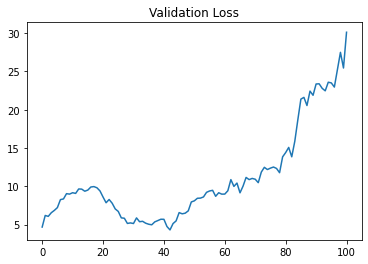

In [14]:
validation_loss = []
with torch.no_grad():
    model_.eval() #stops dropout
    for i in range(X_val.shape[0]):
        x_input = X_val[i:i+1,:,:]
        y_target = y_val[i:i+1,:,:]
        
        y_hat = model_(x_input)                   
        val_loss = loss(y_hat, y_target)
        validation_loss.append(val_loss.item())
        
print('average validaiton loss :', np.mean(np.array(validation_loss)))
plt.plot(np.arange(len(validation_loss)),validation_loss,label='Loss')
plt.title('Validation Loss')

In [15]:
model_.eval()
forecasted = []
for sample in range(X_fore.shape[0]):
    sample_input = X_fore[sample:sample+1,:,:]
    y_pred_fore = model_(sample_input)
    print(X_fore[sample:sample+1,0:1,:])
    print(y_pred_fore)
    y_pred_fore_val = y_pred_fore.detach().numpy().reshape(-1) # entirety of model ouput in 1D array
    y_fore_hat = y_pred_fore_val[y_pred_fore.shape[2]-forecast_size:] # forcasted aka shifted y, take last forecast_size elements
    forecasted.append(y_fore_hat[0])
    print(y_fore_hat)
    

tensor([[[296.2600, 309.0900, 300.2400, 312.8600, 302.4600, 297.4600, 274.2300,
          288.4200, 274.3600, 248.1100, 269.3200, 239.8500, 252.8000, 240.0000,
          240.5100, 228.8000, 222.9500, 243.1500, 246.7900, 261.2000]]])
tensor([[[295.5352, 308.2050, 298.6119, 309.7364, 299.9129, 295.0651, 275.6481,
          286.4993, 274.2622, 251.4241, 268.1603, 243.0930, 256.1805, 242.5055,
          242.9831, 231.4538, 228.4230, 244.3334, 248.6367, 261.2863]]],
       grad_fn=<ReluBackward0>)
[261.28625]
tensor([[[309.0900, 300.2400, 312.8600, 302.4600, 297.4600, 274.2300, 288.4200,
          274.3600, 248.1100, 269.3200, 239.8500, 252.8000, 240.0000, 240.5100,
          228.8000, 222.9500, 243.1500, 246.7900, 261.2000, 253.4200]]])
tensor([[[308.2106, 297.9893, 309.8205, 299.9129, 295.0651, 275.6481, 286.4993,
          274.2091, 251.4241, 268.1603, 243.0930, 256.1805, 242.5055, 242.9831,
          231.4538, 228.4230, 244.3334, 248.6367, 261.2863, 254.6913]]],
       grad_fn=<ReluBack

Actual:  [253.42 261.65 257.75 246.15 251.83 248.19 264.86 265.13 274.03 278.2
 275.66 283.79 277.76 279.1  286.64 281.59 273.04 279.1  279.08 282.97
 287.05 285.73 293.21 290.48 282.79 283.57 286.19 284.25 287.68 292.44
 292.5  286.67 281.6  284.97 286.28 295.   291.97 296.93 294.88 295.44
 299.08 303.53 302.97 304.32 305.55 308.08 312.18 311.36 319.34 323.2
 320.79]
Forecasted:  [261.28625, 254.69133, 263.78885, 259.1422, 248.57436, 252.90025, 249.72186, 265.16284, 265.93817, 273.92874, 277.93103, 276.1101, 283.31558, 277.94366, 278.84326, 285.6602, 281.7456, 273.638, 278.7331, 278.8096, 282.25974, 286.61807, 285.4128, 292.12115, 289.71133, 282.39224, 283.31747, 285.6273, 283.78793, 286.78192, 291.18536, 291.8793, 286.28073, 281.2715, 284.12808, 285.29904, 293.93057, 291.2496, 295.63657, 293.7438, 294.07922, 297.84827, 301.9845, 301.47253, 302.59326, 304.26227, 306.54218, 310.31857, 309.52692, 316.78748, 321.0779]
MSE Loss for forecasted value(s):  31.659204277557887
Loss on the Doll

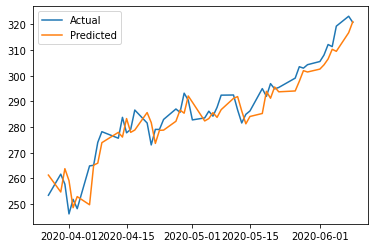

In [16]:
# last forecast_size sample, here these are the actual values of t+1,t+2... 
#assuming sliding window style
y_pred_actual = forecast['close'].tail(X_fore.shape[0])

plt.plot(y_pred_actual.index,y_pred_actual,label = 'Actual')
plt.plot(y_pred_actual.index,forecasted,label = 'Predicted')
plt.legend()
print('Actual: ',y_pred_actual.to_numpy())
print('Forecasted: ',forecasted )

forecasted_loss = mean_squared_error(forecasted,y_pred_actual.to_numpy())
print('MSE Loss for forecasted value(s): ', forecasted_loss)
print('Loss on the Dollar: ', np.sum(y_pred_actual.to_numpy() - forecasted))